# Simulated signal recovery in the presence of flagged RFI
Take simulated data plus noise and add RFI flags. Then, try to recover unbiased estimates of (uncut) true signal and covariance

## Generate simulated data and RFI flag pattern

In [1]:
%matplotlib inline
import numpy as np
import pylab as P

In [2]:
Nterms = 18 ## No. of terms to use when generating FG spectrum
sigma_n0 = 1e-2 # Noise level
sigma_s0 = 2e-1 # Signal amplitude

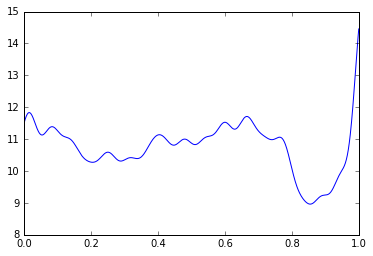

In [3]:
# Generate spectrum with random smooth-ish structure
np.random.seed(11)
nu = np.arange(1024).astype(float)
x = nu / nu[-1]

# Build random polynomials up to order 'Nterms'
basis_c = np.array([np.cos(2.*np.pi*n*x) for n in range(Nterms)])
basis_s = np.array([np.sin(2.*np.pi*n*x) for n in range(Nterms)])
coeffs_c = np.random.rand(Nterms) / (np.arange(Nterms) + 1.)**1.5
coeffs_s = np.random.rand(Nterms) / (np.arange(Nterms) + 1.)**1.5

# Combine into semi-smooth spectrum
spec = np.sum( np.atleast_2d(coeffs_c).T * basis_c, axis=0) \
     + np.sum( np.atleast_2d(coeffs_s).T * basis_s, axis=0)
spec = 5.*(x+0.5) * spec + 10.

P.plot(x, spec)
P.show()

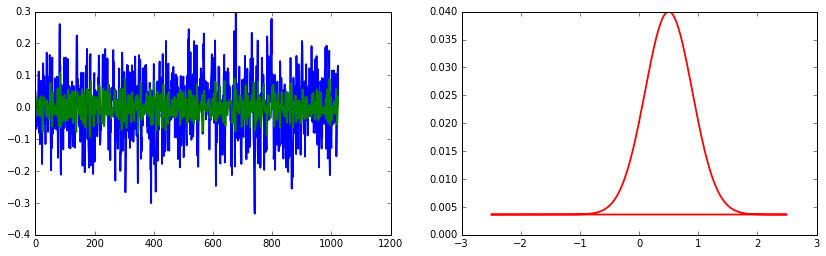

In [4]:
# Construct Gaussian random signal vector
pk = lambda k: sigma_s0**2. * (0.1 + np.exp(-0.5 * (k - 0.5)**2. / (0.4)**2.))/1.1
k = np.fft.fftfreq(x.size, d=0.2)

unit_s = np.random.randn(x.size)
s = np.fft.fft(unit_s) * np.sqrt(pk(k))
s[0] = 0.
s = np.fft.ifft(s)

P.subplot(121)
P.plot(s.real, lw=1.8)
P.plot(s.imag, lw=1.8)

# FIXME: Just take the real part for now; should guarantee real by construction instead though
s = s.real

P.subplot(122)
P.plot(k, pk(k), 'r-', lw=1.8)

P.gcf().set_size_inches((14., 4.))
P.show()


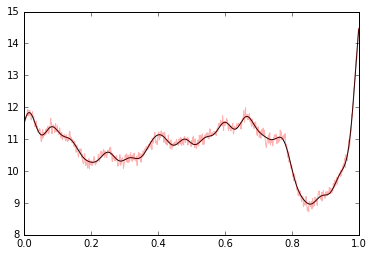

In [5]:
# Add noise and construct data vector
sigma_n = sigma_n0 * (1.+x)
unit_n = np.random.randn(spec.size)
n = unit_n * sigma_n
d = spec + s + n

P.plot(x, spec, 'k-')
P.plot(x, d, 'r-', alpha=0.3)
P.show()

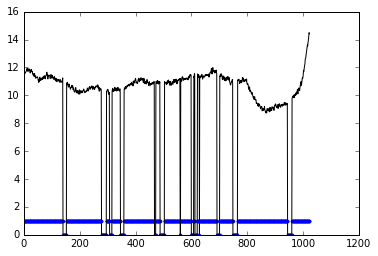

In [6]:
# Add simulated RFI mask
def simulate_rfi_mask(bins, n, max_width=10):
    """
    Randomly generate RFI mask with random locations and widths.
    """
    mask = np.ones(bins)
    locs = np.random.randint(low=0, high=bins, size=n)
    widths = np.random.randint(low=1, high=max_width, size=n)
    for i, l in enumerate(locs):
        mask[l:l+widths[i]] = 0.
    return mask

w = simulate_rfi_mask(d.size, 15, max_width=20)
P.plot(w, marker='.', ls='none')
P.plot(d*w, 'k-')
P.show()

# Construct Wiener filter operators
Start with initial 'guess' for signal covariance

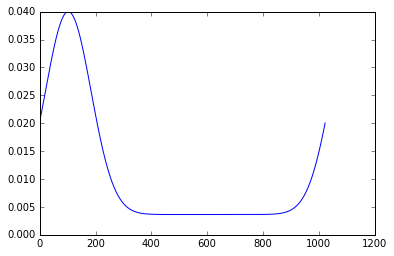

In [7]:
# Construct initial noise and signal covariance matrices
Ninv = np.eye(d.size) / sigma_n**2.
Sk = np.eye(d.size) * pk(k)
Skinv = np.eye(d.size) / pk(k)
Sk[0,0] = Skinv[0,0] = 0.

P.plot(np.diag(Sk))
P.show()

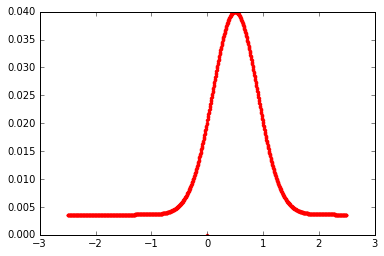

In [8]:
P.plot(k, np.diag(Sk), 'r.')

In [104]:
def T_signal(Ns):
    """
    Project signal amplitudes to data vector space.
    """
    # Trivial; amplitude of signal in each frequency channel
    return np.eye(Ns)


def T_continuum(Nc, nu):
    """
    Project continuum amplitudes to data vector space.
    """
    # Continuum amplitudes are coefficients of power series
    T = np.zeros((Nc, nu.size))
    for i in range(Nc):
        T[i] = (nu/nu[-1])**float(i)
    return T


def apply_mat(x, nu, Ninv, Skinv):
    """
    Apply matrix operator to solution vector, A.x.
    """
    y = np.zeros(x.size)
    
    # Projection operators
    Nc = x.size - nu.size
    Ts = T_signal(nu.size)
    Tc = T_continuum(Nc, nu)
    
    # Separate signal and continuum solution blocks
    x_s = x[:nu.size]
    x_c = x[nu.size:]
    ##x_c = x
    
    # Apply prior matrix to signal part (in Fourier space)
    y[:nu.size] += np.fft.ifft( np.dot(Skinv, np.fft.fft(x_s)) ).real
    
    # Apply inverse noise weight to projected solution blocks, N^-1 T x
    y_s = np.dot(Ninv, np.dot(Ts.T, x_s))
    y_c = np.dot(Ninv, np.dot(Tc.T, x_c))
    
    # Add results of matrix application to output vector
    y[:nu.size] += np.dot(Ts, y_s)
    y[:nu.size] += np.dot(Ts, y_c)
    y[nu.size:] += np.dot(Tc, y_s)
    y[nu.size:] += np.dot(Tc, y_c)
    ##y += np.dot(Tc, y_c)
    return y

    
def rhs(d, nu, Nc, Ninv, sample=False):
    """
    Calculate the RHS of the linear system, b.
    """
    # Projection operators
    Ns = d.size
    Ts = T_signal(d.size)
    Tc = T_continuum(Nc, nu)
    
    # Construct RHS vector
    b0 = np.dot(Ninv, d)
    b_signal = np.dot(Ts, b0)
    b_continuum = np.dot(Tc, b0)
    
    # Construct RHS vector
    b = np.concatenate((b_signal, b_continuum))
    
    # Add random terms (for sampling) if requested
    if sample:
        # Add random term for signal prior, S^-1/2 . omega
        omega_s = np.random.randn(nu.size)
        #b_s = np.dot(np.linalg.cholesky(Skinv), np.fft.fft(omega_s))
        b_s = np.dot(np.sqrt(Skinv), np.fft.fft(omega_s))
        b_s = np.fft.ifft(b_s).real # FIXME: Should guarantee real result by construction

        # Add random term for noise, (U^T N^-1 U)^1/2 . omega
        # FIXME: Performing sqrt on N^-1 directly, to avoid issues with mask
        omega_n = np.random.randn(Ns+Nc)
        yn_c = np.dot(np.sqrt(Ninv), Tc.T)
        yn_s = np.dot(np.sqrt(Ninv), Ts.T)

        # Build U^T N^-1 U operator and take sqrt
        mat = np.zeros((Ns+Nc, Ns+Nc))
        mat[:Ns,:Ns] = np.dot(Ts, yn_s)
        mat[Ns:,Ns:] = np.dot(Tc, yn_c)
        mat[:Ns,Ns:] = np.dot(Ts, yn_c)
        mat[Ns:,:Ns] = np.dot(Tc, yn_s)
        #b_n = np.dot(np.linalg.cholesky(mat), omega_n) # Can't use this as there are zeros in Ninv (due to mask)
        b_n = np.dot(mat, omega_n)
    
        # Add random terms 
        b[:Ns] += b_s
        b[:] += b_n
        
    return b


def conj_grad(x_in, nu, b, Ninv, Skinv, tol=1e-6, Niter=200):
    """
    Apply conjugate gradient method to solve linear system.
    """
    # Calculate initial residual and its norm
    x = x_in.copy()
    r = b - apply_mat(x, nu, Ninv, Skinv)
    res = np.dot(r.T, r)
    p = r.copy()
    
    # Iterate CG solver
    i = 0
    while res > tol and i < Niter:
        if i % 100 == 0: print("%3d : %3.3e / %3.3e" % (i, res, tol))
        
        # CG: Calculate correction amplitude, alpha_k
        A_dot_p = apply_mat(p, nu, Ninv, Skinv)
        alpha = res / np.dot(p.T, A_dot_p)
        
        # Calculate next iteration
        x = x + alpha * p
        r = r - alpha * A_dot_p
        
        # Calculate new residual vector
        res_new = np.dot(r.T, r)
        
        # Update conjugate vector and residual
        beta = res_new / res
        res = res_new
        p = r + beta*p
        
        # Increment iteration counter
        i += 1
    print "\tIters: %d" % i
    return x, r
    

In [105]:
def solve_system(x=None, sample=False):
    Nc = 25 # No. of continuum modes to fit

    # Apply mask to Ninv
    wNinv = Ninv.copy()
    wNinv[np.diag_indices(Ninv.shape[0])] = wNinv[np.diag_indices(Ninv.shape[0])] * w

    # Calculate RHS
    b = rhs(d*w, nu, Nc, wNinv, sample=sample)

    # Initial guess of solution (zero for signal, O(1) for continuum coeffs)
    if x is None:
        x = np.zeros(b.size)
        x[nu.size:] = [
            1.158e+01, -1.009e+01, 1.758e+01, 5.663e+00, -4.031e+00, -7.466e+00, -7.209e+00, -5.396e+00, 
            -3.179e+00, -1.098e+00, 6.267e-01, 1.932e+00, 2.827e+00, 3.359e+00, 3.585e+00, 4.219e-01, 
            4.156e-01, 4.091e-01, 4.025e-01, 3.959e-01, 3.893e-01, 3.827e-01, 3.762e-01, 3.698e-01, 3.635e-01 ]

    # Solve system usign CG search
    x_bf, r = conj_grad(x, nu, b, wNinv, Skinv, Niter=5000)
    print "\tFinal res = %4.4e" % np.dot(r.T, r)
    return x_bf

In [106]:
# Solve linear system once (with one random realisation)
x1 = solve_system(sample=True)

  0 : 3.612e+11 / 1.000e-06
100 : 5.488e+02 / 1.000e-06
200 : 2.330e+04 / 1.000e-06
300 : 5.263e+03 / 1.000e-06
400 : 3.011e+04 / 1.000e-06
500 : 2.581e-03 / 1.000e-06
600 : 1.853e+03 / 1.000e-06
700 : 1.892e+00 / 1.000e-06
800 : 4.813e+01 / 1.000e-06
900 : 4.189e-02 / 1.000e-06
1000 : 4.041e-04 / 1.000e-06
	Iters: 1028
	Final res = 8.2030e-07


In [111]:
# Solve system again, with new random realisation, but using previous soln. as starting point
x2 = solve_system(x1, sample=True)

  0 : 1.476e+10 / 1.000e-06
100 : 4.518e+01 / 1.000e-06
200 : 1.303e+04 / 1.000e-06
300 : 1.412e+02 / 1.000e-06
400 : 2.821e+03 / 1.000e-06
500 : 7.528e-03 / 1.000e-06
600 : 7.681e+01 / 1.000e-06
700 : 1.682e-01 / 1.000e-06
800 : 2.712e+01 / 1.000e-06
900 : 2.421e+01 / 1.000e-06
1000 : 9.256e-06 / 1.000e-06
	Iters: 1008
	Final res = 9.6471e-07


In [113]:
# Repeat for a few more realisations
x_results = []
for i in range(5):
    print "===> %d" % i
    x_results.append( solve_system(x1, sample=True) )

===> 0
  0 : 7.816e+09 / 1.000e-06
100 : 6.953e+02 / 1.000e-06
200 : 2.874e+01 / 1.000e-06
300 : 4.462e+02 / 1.000e-06
400 : 8.494e+01 / 1.000e-06
500 : 9.669e-04 / 1.000e-06
600 : 1.396e+03 / 1.000e-06
700 : 8.992e+00 / 1.000e-06
800 : 2.027e+00 / 1.000e-06
900 : 1.037e+00 / 1.000e-06
1000 : 3.954e-02 / 1.000e-06
1100 : 9.247e+01 / 1.000e-06
1200 : 4.736e+00 / 1.000e-06
1300 : 5.367e+00 / 1.000e-06
	Iters: 1382
	Final res = 9.2784e-07
===> 1
  0 : 1.578e+10 / 1.000e-06
100 : 1.138e+04 / 1.000e-06
200 : 5.933e+01 / 1.000e-06
300 : 3.626e+01 / 1.000e-06
400 : 3.243e+02 / 1.000e-06
500 : 5.388e-04 / 1.000e-06
600 : 1.108e+02 / 1.000e-06
700 : 7.523e-02 / 1.000e-06
	Iters: 758
	Final res = 5.5430e-07
===> 2
  0 : 2.021e+10 / 1.000e-06
100 : 1.107e+03 / 1.000e-06
200 : 7.884e-01 / 1.000e-06
300 : 1.507e+03 / 1.000e-06
400 : 3.222e+01 / 1.000e-06
500 : 5.368e-05 / 1.000e-06
600 : 1.069e+02 / 1.000e-06
700 : 8.999e+00 / 1.000e-06
800 : 1.279e+00 / 1.000e-06
900 : 2.390e-03 / 1.000e-06
1000 :

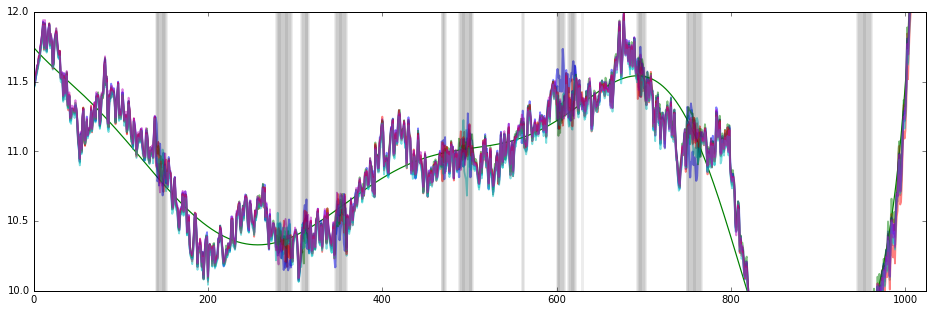

In [147]:
## Check solution
#print ", ".join(["%3.3e" % _x for _x in x])
ys1 = np.dot(x1[:nu.size], T_signal(nu.size))
yc1 = np.dot(x1[nu.size:], T_continuum(x1.size - nu.size, nu))
ys2 = np.dot(x2[:nu.size], T_signal(nu.size))
yc2 = np.dot(x2[nu.size:], T_continuum(x1.size - nu.size, nu))

P.plot(nu, d, 'b-', lw=2.2, alpha=0.5)
#P.plot(nu, d*w, 'b-', lw=2.2, alpha=0.5)
#P.plot(nu, w, 'm-', lw=1.8, alpha=0.2)
P.plot(nu, yc1, 'g-', lw=1.2)

# Realisations 1 and 2
P.plot(nu, yc1 + ys1, 'r-', lw=1.8, alpha=0.5)
P.plot(nu, yc2 + ys2, 'c-', lw=1.8, alpha=0.5)

for i in range(len(x_results)):
    xr = x_results[i]
    _ys = np.dot(xr[:nu.size], T_signal(nu.size))
    _yc = np.dot(xr[nu.size:], T_continuum(xr.size - nu.size, nu))
    P.plot(nu, _yc + _ys, lw=1.8, alpha=0.5)
#P.plot(nu, w*100., 'k-', alpha=0.2)

for i in range(w.size):
    if w[i] < 0.9: P.axvline(i, color='k', alpha=0.07, lw=3.)

P.xlim((0., 1024.))
#P.ylim((10.5, 11.2))
P.ylim((10., 12.))

P.gcf().set_size_inches((16., 5.))
P.show()

In [124]:
# Fit polynomial to the data directly
#coeffs = np.polyfit(nu/nu[-1], d*w, deg=50, w=np.sqrt(np.diag(wNinv)))[::-1]
#coeffs_cheb = np.polynomial.chebyshev.chebfit(nu/nu[-1], d*w, deg=20, w=np.sqrt(np.diag(wNinv)))[::-1]
#coeffs_herm = np.polynomial.hermite.hermfit(nu/nu[-1], d*w, deg=20, w=np.sqrt(np.diag(wNinv)))[::-1]
#coeffs_lag = np.polynomial.laguerre.lagfit(nu/nu[-1], d*w, deg=20, w=np.sqrt(np.diag(wNinv)))[::-1]

In [126]:
# Compare direct polynomial fit to CG solution
#yc = np.dot(x, T_continuum(Nc, nu)) # Project CG solution into data space
#y_poly = np.poly1d(coeffs[::-1])(nu/nu[-1])
#y_cheb = np.polynomial.chebyshev.chebval(nu/nu[-1], coeffs_cheb[::-1])
#y_herm = np.polynomial.hermite.hermval(nu/nu[-1], coeffs_herm[::-1])
#y_lag = np.polynomial.laguerre.lagval(nu/nu[-1], coeffs_lag[::-1])

#P.plot(nu, d, 'k-', lw=1.8)
#P.plot(nu, d - y_poly, 'g-', lw=1.8)
#P.plot(nu, d - y_cheb, 'r-', lw=1.8)
#P.plot(nu, d - y_herm, 'y-', lw=1.8)
#P.plot(nu, d - y_lag, 'm-', lw=1.8)
#P.plot(nu, d - yc, 'b-', lw=1.8)
#P.plot(nu, , 'r-', lw=1.8)
#P.show()

# Compare delay spectrum with and without constrained realisation
The main effect of the RFI flagging window function can be seen in the delay spectrum (c.f. Parsons & Backer 2009, Fig. 2). Using the constrained realisation code should hopefully bring it much closer to the true delay spectrum.

In [123]:
ktau = np.fft.fftfreq(nu.size, d=nu[1]-nu[0]) # Define Fourier wavenumbers in delay space

In [135]:
# Get delay spectra (FTs of frequency spectra)
ds_true = np.fft.fft(d)
ds_rfi = np.fft.fft(d*w)
ds_cr = np.fft.fft(yc1 + ys1)

# Calculate PSDs
psd_true = ds_true * ds_true.conj()
psd_rfi = ds_rfi * ds_rfi.conj()
psd_cr = ds_cr * ds_cr.conj()

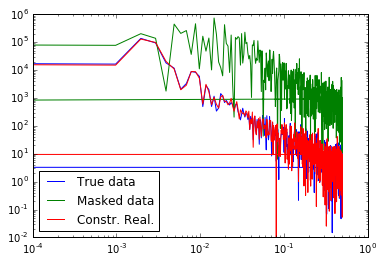

In [144]:
P.plot(ktau, psd_true, label="True data")
P.plot(ktau, psd_rfi, label="Masked data")
P.plot(ktau, psd_cr, label="Constr. Real.")
P.legend(loc='lower left', frameon=True)
P.yscale('log')
P.xscale('log')
P.ylim((1e-2, 1e6))
P.show()